# Violent Crime Rate in Canadian Cities and Provinces.
Using 6 different datasets from statistics Canada, We are trying to predict the annual violent crime rate in canadian cities. Datasets used are:
- [Incident-based crime statistics, by detailed violations.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017701)
- [Low income entry and exit rates of tax filers in Canada.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110002401)
- [Labour force characteristics by census metropolitan area, annual.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410046101)
- [Summary characteristics of Canadian tax filers preliminary T1 Family File.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1110004701)
- [Consumer Price Index, annual average, not seasonally adjusted.](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000501)
- [Police personnel and selected crime statistics, municipal police services](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510007701)

Total violent criminal code violations rate per 100k residents is the target variable. Predictors are:
- Unemployment Rate.
- CPI inflation adjusted income.
- Low income immobility rate.
- Police officers per 100,000 population.

The data is per year per census metro area.

[Github Repo](https://github.com/Bilal1k/Crime)

Note:

I'm reusing the data and some EDA work from my previous project for supervised learning. This will help compare the 2 approaches and show how unsupervised learning can add value to a project.


### Problem Statement

The central problem addressed by this project is accurately predicting violent crime rates at a city level and understand crime rates relationship with other socio-economic factors. Reliable predictions enable policymakers and law enforcement agencies to implement targeted and effective preventive measures, optimizing resource allocation and community safety.

In [1]:
# Load packages
import requests
import zipfile
import io
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression



### Data Acquisition and Cleaning

Data acquisition involved downloading and preprocessing several large datasets. Due to the size of these datasets, specialized chunk-wise processing was necessary. Data cleaning included geographical adjustments, particularly splitting areas such as Ottawa-Gatineau into distinct cities, and addressing missing or anomalous values.

In [2]:
# Download, read, preprocess and merge data.
def download_and_extract_csv(url):
    """
    Downloads a ZIP file from the given URL, extracts it,
    and returns the path to the first CSV file that does not contain 'meta' in its name.
    """
    print("Downloading zip file from " + url)
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file. Status code: {response.status_code}")
    else:
        print("Download Complete")
    # Create a temporary directory
    temp_dir = tempfile.mkdtemp()
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Filter CSV files that do not contain 'meta'
        csv_files = [name for name in z.namelist() if name.endswith('.csv') and 'meta' not in name.lower()]
        
        if not csv_files:
            raise FileNotFoundError("No non-meta CSV files found in the ZIP archive.")
        
        # Extract the first matching CSV file
        csv_name = csv_files[0]
        extracted_path = os.path.join(temp_dir, os.path.basename(csv_name))
        with z.open(csv_name) as source, open(extracted_path, 'wb') as target:
            target.write(source.read())
    
    return extracted_path

def clean_geo_columns(df, city_col='City'):
    # Remove non-Census data
    df = df[~df[city_col].str.contains("Non-Census", na=False)]

    # Split 'City' column into City and Province
    split_cols = df[city_col].str.split(', ', expand=True)
    df['City'] = split_cols[0]
    df['Province'] = split_cols[1] if split_cols.shape[1] > 1 else None

    # Remove [number] suffix from City names
    df['City'] = df['City'].str.replace(r'\s*\[\d+\]', '', regex=True)
    # Split CMA tag if present
    if df['Province'].str.contains(r'\[', na=False).any():
        df[['Province', 'CMA']] = df['Province'].str.split(' \\[', expand=True)
        df['CMA'] = df['CMA'].str.replace(']', '')

    return df

def split_ottawa_gatineau(df):
    # Replace Ottawa-Gatineau with separate rows
    df.loc[(df['City'] == 'Ottawa-Gatineau') & (df["Province"] == 'Ontario part'), 'City'] = 'Ottawa'
    df.loc[(df['City'] == 'Ottawa-Gatineau') & (df["Province"] == 'Quebec part'), 'City'] = 'Gatineau'
    df.loc[df["Province"] == 'Ontario part', 'Province'] = 'Ontario'
    df.loc[df["Province"] == 'Quebec part', 'Province'] = 'Quebec'
    return df[df['City'] != 'Ottawa-Gatineau']

# Filter and save violent crime rate data without fully loading into memory. dataset is 1.7 GB, cannot load into memory.
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/35100177-eng.zip')
output_path = './data/crimeStat/crimeRate.csv'
chunksize = 100_000
first_chunk = True

for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
    filtered_chunk = chunk[
        (chunk['Violations'] == 'Total violent Criminal Code violations [100]') &
        (chunk['Statistics'] == 'Rate per 100,000 population')
    ]
    if not filtered_chunk.empty:
        filtered_chunk.to_csv(output_path, mode='a', index=False, header=first_chunk)
        first_chunk = False

# Load and clean Crime data
dfCrime = pd.read_csv(output_path)[["REF_DATE", "GEO", "VALUE"]]
dfCrime.columns = ["Year", "City", "CrimeRate"]

dfCrime = dfCrime[
    (dfCrime["Year"] != "REF_DATE") 
]

dfCrime["Year"] = dfCrime["Year"].astype(int)
dfCrime["CrimeRate"] = pd.to_numeric(dfCrime["CrimeRate"], errors="coerce")
dfCrime = clean_geo_columns(dfCrime)
dfCrime = split_ottawa_gatineau(dfCrime)
dfCrime.dropna(subset=["CrimeRate"], inplace=True)

# Load and clean Unemployment data
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/14100461-eng.zip')
dfUnemp = pd.read_csv(file_path)
dfUnemp = dfUnemp[
    (dfUnemp["Labour force characteristics"] == "Unemployment rate") &
    (dfUnemp["Gender"] == "Total - Gender") &
    (dfUnemp["Age group"] == "25 to 54 years")
][["REF_DATE", "GEO", "VALUE"]]
dfUnemp.columns = ["Year", "City", "UnemploymentRate"]
dfUnemp["Year"] = dfUnemp["Year"].astype(int)
dfUnemp = clean_geo_columns(dfUnemp)
dfUnemp = split_ottawa_gatineau(dfUnemp)

# Load and clean Low Income Immobility Rate data
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/11100024-eng.zip')
dfMob = pd.read_csv(file_path)
dfMob = dfMob[
    (dfMob["Statistics"] == "Low income immobility rate") &
    (dfMob["Low income threshold"] == "Variable low income measure") &
    (dfMob["Selected characteristics"] == "Both sexes")
]
dfMob[['PrevYear', 'Year']] = dfMob['REF_DATE'].str.split('/', expand=True)
dfMob = dfMob[["Year", "GEO", "VALUE"]]
dfMob.columns = ['Year', 'City', 'lowIncImmobRate']
dfMob["Year"] = dfMob["Year"].astype(int)
dfMob = clean_geo_columns(dfMob)
dfMob = split_ottawa_gatineau(dfMob)

# Load and clean Income and CPI data
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/11100047-eng.zip')
dfInc = pd.read_csv(file_path, dtype={'STATUS': str, 'TERMINATED': str})

file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/18100005-eng.zip')
dfCPI = pd.read_csv(file_path)
dfMedInc = dfInc[dfInc["Canadian tax filers"] == "Median employment income of tax filers"]
dfMedInc = dfMedInc[["REF_DATE", "GEO", "VALUE"]]
dfMedInc.columns = ["Year", "City", "MedInc"]
dfMedInc["Year"] = dfMedInc["Year"].astype(int)

dfCPI = dfCPI[dfCPI["Products and product groups"] == "All-items"][["REF_DATE", "VALUE"]]
dfCPI.columns = ["Year", "CPI"]
dfCPI["Year"] = dfCPI["Year"].astype(int)

dfMedInc = pd.merge(dfMedInc, dfCPI, on="Year", how="left")
dfMedInc['MedInc'] = dfMedInc['MedInc'].astype(float)
dfMedInc['CPI'] = dfMedInc['CPI'].astype(float)
dfMedInc = clean_geo_columns(dfMedInc)
dfMedInc = split_ottawa_gatineau(dfMedInc)

# Adjust income for inflation
target_cpi = 160.9 # 2024
dfMedInc['infAdjInc'] = ((dfMedInc['MedInc'] / dfMedInc['CPI']) * target_cpi).round(-2)

# Police officers per 100,000 population
file_path = download_and_extract_csv('https://www150.statcan.gc.ca/n1/tbl/csv/35100077-eng.zip')
dfPol = pd.read_csv(file_path)
dfPol = dfPol[
    (dfPol["Statistics"] == "Police officers per 100,000 population") 
]

dfPol["Year"] = dfPol["REF_DATE"].astype(int)
dfPol = dfPol[["Year", "GEO", "VALUE"]]
dfPol.columns = ['Year', 'City', 'policeRate']
dfPol = clean_geo_columns(dfPol)
dfPol.dropna(subset=["policeRate"], inplace=True)

# Merge all data sets
df = pd.merge(dfCrime, dfUnemp, on=["Year", "City", "Province"], how="left")
df = pd.merge(df, dfMob, on=["Year", "City", "Province"], how="left")
df = pd.merge(df, dfMedInc, on=["Year", "City", "Province"], how="left")
df = pd.merge(df, dfPol, on=["Year", "City", "Province"], how="left")

# Remove variables that are confounded with each other or not needed.
df = df.drop(columns=["CPI","MedInc",'CMA'])
df.to_csv("data/cleanData.csv", index=False)

Download Complete
Download Complete
Download Complete
Download Complete
Download Complete
Download Complete


In [5]:
df = pd.read_csv("data/cleanData.csv")
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66892 entries, 0 to 66891
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              66892 non-null  int64  
 1   City              66892 non-null  object 
 2   CrimeRate         66892 non-null  float64
 3   Province          46762 non-null  object 
 4   UnemploymentRate  26220 non-null  float64
 5   lowIncImmobRate   49608 non-null  float64
 6   infAdjInc         66722 non-null  float64
 7   policeRate        37254 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.1+ MB
None
               Year     CrimeRate  UnemploymentRate  lowIncImmobRate  \
count  66892.000000  66892.000000      26220.000000     49608.000000   
mean    2012.149794   1703.712473          5.301602        71.244706   
std        6.895256   1765.580550          1.430577         5.182136   
min     1998.000000    528.820000          2.200000        51.60000

### Outlier removal and Standardization

To improve the reliability of the analysis, multivariate outliers were identified and removed using three distinct anomaly detection techniques. First, the Elliptic Envelope method, which assumes data follows a Gaussian distribution, was used to fit an ellipse around the central data cluster and identify distant points based on Mahalanobis distance. Second, Isolation Forest, a tree-based algorithm, detected anomalies by isolating data points through random partitioning—outliers are isolated more quickly than inliers. Lastly, Local Outlier Factor (LOF) was employed to detect samples that differ significantly from their neighbors in terms of local density. A point was marked as an outlier if it was flagged by any of these methods. The identified outliers were then removed from the dataset to reduce noise and improve model performance. A scatterplot of policeRate vs. CrimeRate illustrates one example of the separation, where red points indicate outliers detected by LOF.

In [6]:

# Outlier removal and Standardization

# Select relevant numeric features
features = ["CrimeRate", "UnemploymentRate", "lowIncImmobRate",'infAdjInc','policeRate']
X = df[features].dropna()

# Method 1: Distance using Elliptic Envelope
ee = EllipticEnvelope(contamination=0.025)
X["Outlier_EllipticEnvelope"] = ee.fit_predict(X)

# Method 2: Isolation Forest
iso_forest = IsolationForest(contamination=0.025, random_state=42)
X["Outlier_IsoForest"] = iso_forest.fit_predict(X)

# Method 3: Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=40, contamination=0.025)
X["Outlier_LOF"] = lof.fit_predict(X)

# Identify outliers
outliers = X[(X["Outlier_EllipticEnvelope"] == -1) | 
              (X["Outlier_IsoForest"] == -1) | 
              (X["Outlier_LOF"] == -1)]

df = df[~df.index.isin(outliers.index)]
print("Percentage of multivariate outliers detected out of the entire dataset:")
print(f"{outliers[["CrimeRate", "UnemploymentRate", "infAdjInc"]].shape[0]/X.shape[0] * 100:.2f}%")

# Standardizing variables
num_cols = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
dfStand = df.copy()
dfStand.drop(columns=['Year'])
dfStand[num_cols] = scaler.fit_transform(df[num_cols])
dfStand["Year"] = df["Year"]


Percentage of multivariate outliers detected out of the entire dataset:
4.92%


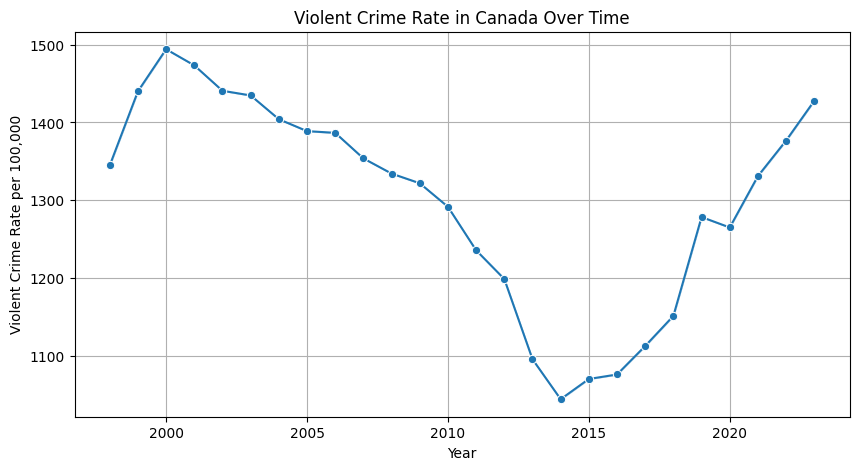

In [7]:
# Plot Crime Rate Over Time for Canada
df_canada = df[df["City"] == "Canada"]
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_canada, x="Year", y="CrimeRate", marker="o")
plt.title("Violent Crime Rate in Canada Over Time")
plt.ylabel("Violent Crime Rate per 100,000")
plt.xlabel("Year")
plt.grid()
plt.show()

The data show a steady decline in violent crime from around 2000 to 2014, reaching a low point near 2014–2015. However, this trend reverses after 2015, with a notable resurgence in violent crime through the late 2010s and early 2020s. While the rate remains below its peak in 2000, the recent upward trend suggests that gains in crime reduction have been eroding.

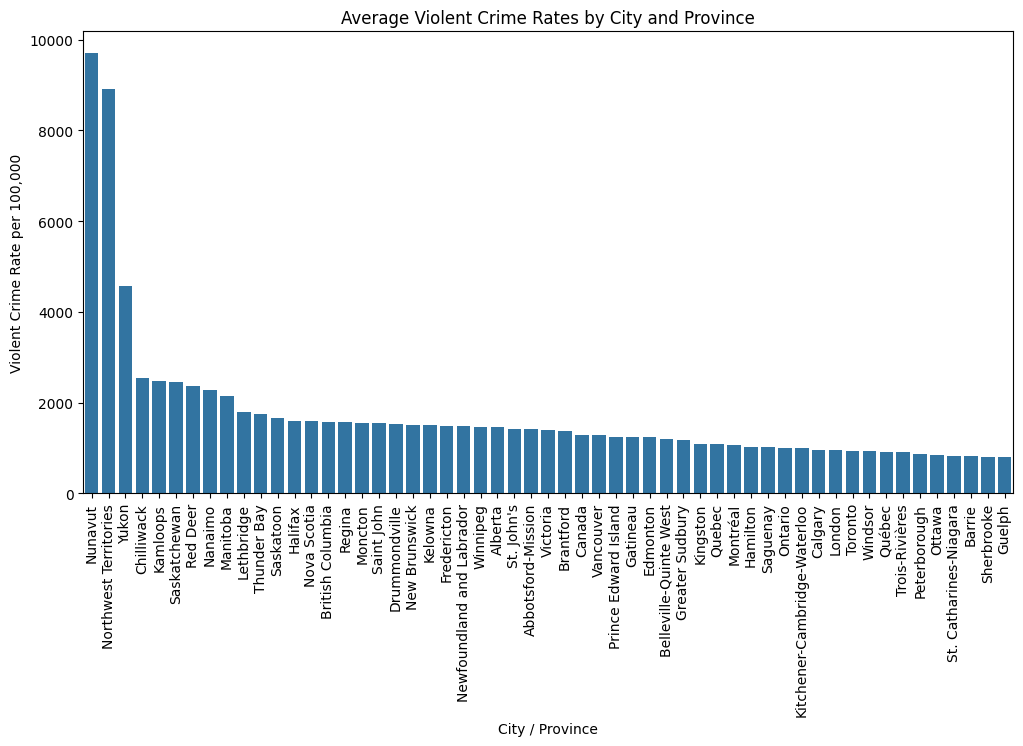

In [8]:
# Compare average Crime Rates in all years across Cities
df_avg = df.groupby("City")["CrimeRate"].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_avg, x="City", y="CrimeRate", order=df_avg.sort_values("CrimeRate", ascending=False)["City"])
plt.xticks(rotation=90)
plt.title("Average Violent Crime Rates by City and Province")
plt.ylabel("Violent Crime Rate per 100,000")
plt.xlabel("City / Province")
plt.show()

The plot suggest a strong geographic divide, with higher crime rates concentrated in northern and some western regions, potentially reflecting differences in socioeconomic conditions, policing resources, and community support systems.

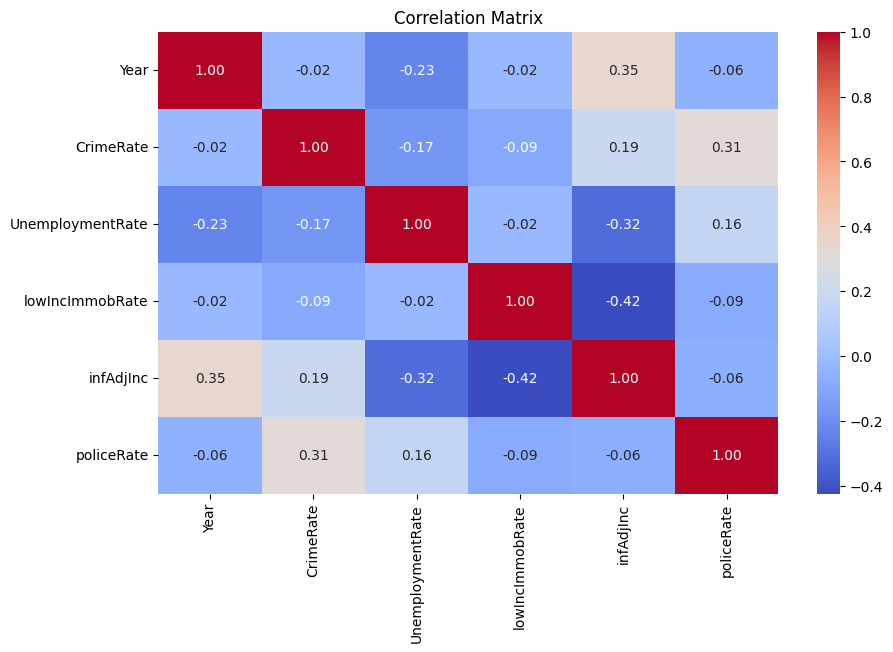

In [9]:
# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(dfStand.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Overall, the correlations are relatively weak, highlighting the importance of multivariate analysis to capture the true drivers of violent crime.

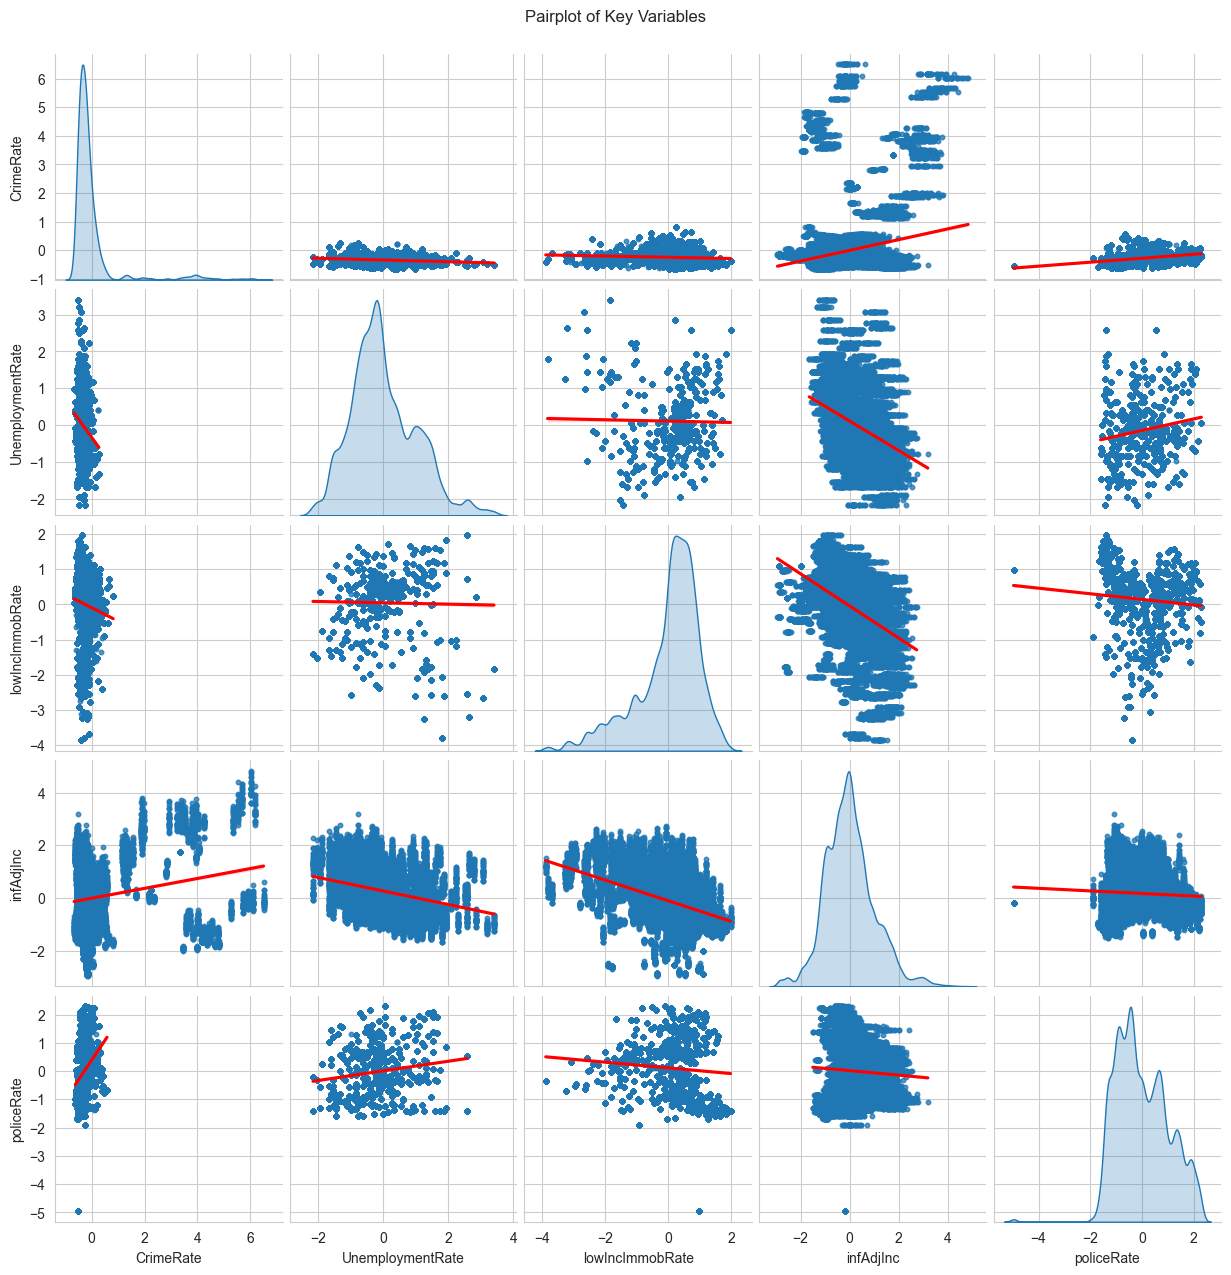

In [10]:
# Standardized pairplot
sns.set_style("whitegrid")
pairplot = sns.pairplot(dfStand, vars=["CrimeRate", "UnemploymentRate", "lowIncImmobRate",'infAdjInc','policeRate'], 
                        kind="reg", diag_kind="kde", markers="o",
                        plot_kws={"scatter_kws": {"alpha": 0.5, "s": 10}, "line_kws": {"color": "red"}})
pairplot.figure.suptitle("Pairplot of Key Variables", y=1.02)
plt.show()

The scatterplots reveal substantial spread and overlap, suggesting potential confounding. In particular, the nonlinear shapes and clustered distributions hint that simple bivariate interpretations may be misleading. These limitations highlight the need for residualized or multivariate plots to uncover more accurate and controlled relationships.

### Residualized Scatter Plots
While the regular pairplot provides a useful overview of marginal relationships between variables, it does not account for the influence of other covariates. To better isolate the unique association between each pair of variables, we implement residualized scatter plots. By removing the effects of all other variables, these plots reveal the partial relationship between two variables, helping us distinguish genuine associations from those driven by shared correlations with confounding factors. This adds analytical clarity and improves our ability to interpret relationships in a multivariate context.

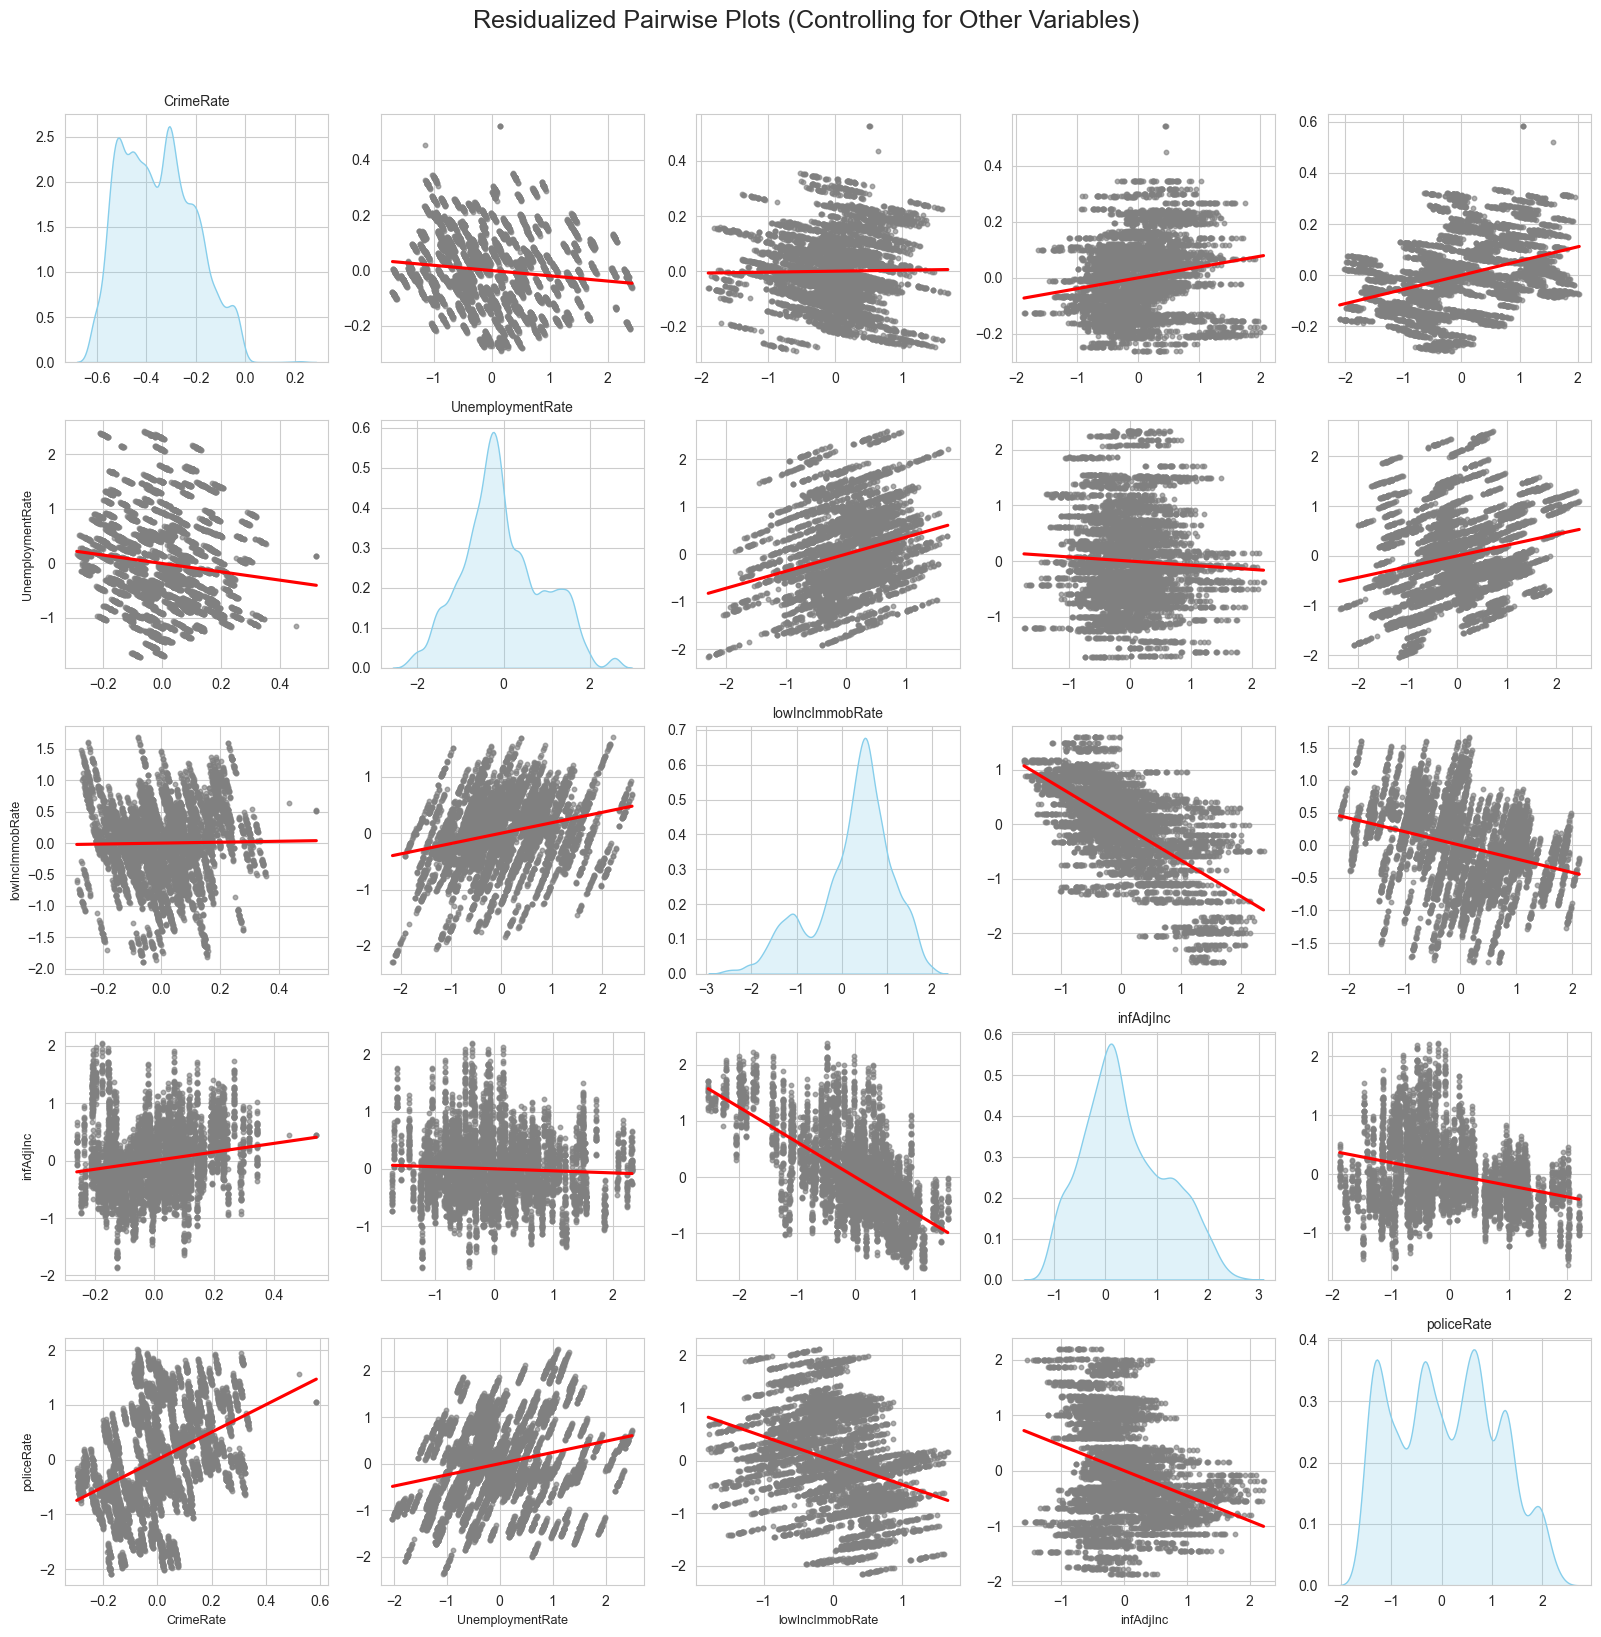

In [11]:
# Variables to analyze
features = ["CrimeRate", "UnemploymentRate", "lowIncImmobRate", "infAdjInc", "policeRate"]
df_clean = dfStand[features].dropna()

def get_residuals(y, X_control):
    model = LinearRegression().fit(X_control, y)
    return y - model.predict(X_control)

# Create plot grid
n = len(features)
fig, axes = plt.subplots(n, n, figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through variable pairs
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        y_var = features[i]
        x_var = features[j]

        if i == j:
            # Diagonal: KDE
            sns.kdeplot(df_clean[x_var], ax=ax, fill=True, color="skyblue")
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_title(x_var, fontsize=10)
        else:
            # Control variables = all other than x_var and y_var
            control_vars = [v for v in features if v not in [x_var, y_var]]
            X_control = df_clean[control_vars]

            # Residualize
            x_resid = get_residuals(df_clean[x_var], X_control)
            y_resid = get_residuals(df_clean[y_var], X_control)

            # Plot residualized relationship
            ax.scatter(x_resid, y_resid, s=10, alpha=0.4, color='gray')
            sns.regplot(x=x_resid, y=y_resid, scatter=False, ax=ax, color='red', ci=None)

            if i == n - 1:
                ax.set_xlabel(x_var, fontsize=9)
            else:
                ax.set_xlabel("")
            if j == 0:
                ax.set_ylabel(y_var, fontsize=9)
            else:
                ax.set_ylabel("")

# Overall title
fig.suptitle("Residualized Pairwise Plots (Controlling for Other Variables)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


The residualized scatter plots reveal the unique relationships between variables after controlling for confounding effects. Notably, infAdjInc (income) shows a strong negative association with both CrimeRate and lowIncImmobRate, suggesting that higher income levels are independently linked to lower crime and reduced low-income immobility. Additionally, policeRate appears positively associated with CrimeRate even after accounting for other variables, potentially indicating a reactive increase in policing where crime is higher. These residualized relationships help uncover true underlying associations that may be obscured in standard correlation or pairplot visualizations.

In [12]:
# Helper Function: Cluster to Label Mapping
def get_cluster_label_mapping(cluster_labels, true_labels):
    """
    Maps each cluster label to the most common true label (majority vote).
    """
    mapping = {}
    for cluster_id in np.unique(cluster_labels):
        majority_label = true_labels[cluster_labels == cluster_id].mode()[0]
        mapping[cluster_id] = majority_label
    return mapping

Now we will apply KMeans clustering to group Canadian cities based on the average values of selected features (e.g., CrimeRate, UnemploymentRate, etc.). By aggregating data at the city level and clustering them into five groups, we aim to uncover distinct city profiles that share similar socio-economic and crime characteristics. The resulting heatmap and radar charts visualizes the average feature values for each cluster, helping us interpret what defines each group — for example, identifying clusters with high crime and unemployment versus those with higher income and low immobility. This approach supports pattern discovery and city analysis based on multivariate characteristics.

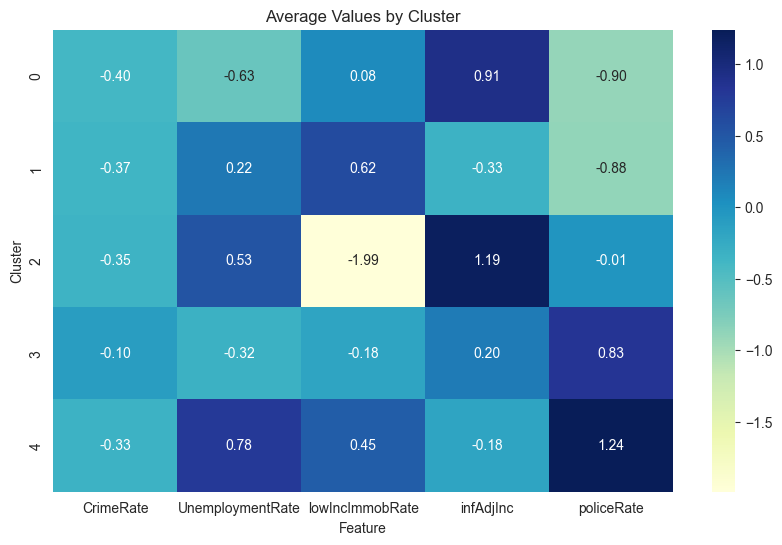

In [ ]:

# to prevent cpu core count warning from KMeans()
os.environ['OMP_NUM_THREADS'] = '4'

y_clustered = dfStand.groupby("City")[features].mean().reset_index().dropna()
X_clustered = y_clustered[features].copy()
kmeans = KMeans(n_clusters=5, random_state=42)
y_clustered["Cluster"] = X_clustered["Cluster"] = kmeans.fit_predict(X_clustered)

colors = plt.get_cmap("tab10")
cluster_colors = {label: colors(i) for i, label in enumerate(sorted(np.unique(X_clustered["Cluster"])))}


# Plots a heatmap of mean feature values grouped by cluster.
cluster_means = X_clustered.groupby("Cluster")[features].mean()
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Values by Cluster")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()


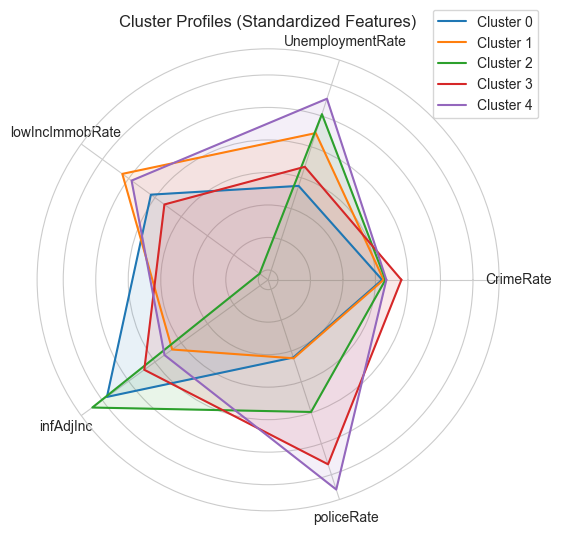

In [14]:

# Displays radar chart comparing feature profiles of each cluster.
labels = cluster_means.columns.tolist()
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].tolist() + [cluster_means.loc[cluster].tolist()[0]]
    ax.plot(angles, values, label=f"Cluster {cluster}", color=cluster_colors[cluster])
    ax.fill(angles, values, alpha=0.1, color=cluster_colors[cluster])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([])
ax.set_title("Cluster Profiles (Standardized Features)")
ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.show()

### PCA Cluster Visualization
This plot displays Canadian cities projected into two principal components using PCA, allowing us to visualize clustering patterns based on multiple socio-economic and crime-related features. Each city is colored by its assigned KMeans cluster, helping reveal distinct groupings in reduced dimensions. The spatial separation between clusters suggests meaningful differences in feature profiles, while cities within the same cluster (e.g., Saguenay and Sherbrooke in Cluster 1) share similar characteristics. This visualization aids in understanding how cities group together in a multivariate context, even if the original data had more than two dimensions.

PC1 explains 44.40%, PC2 explains 37.95%, Total explained 82.35%


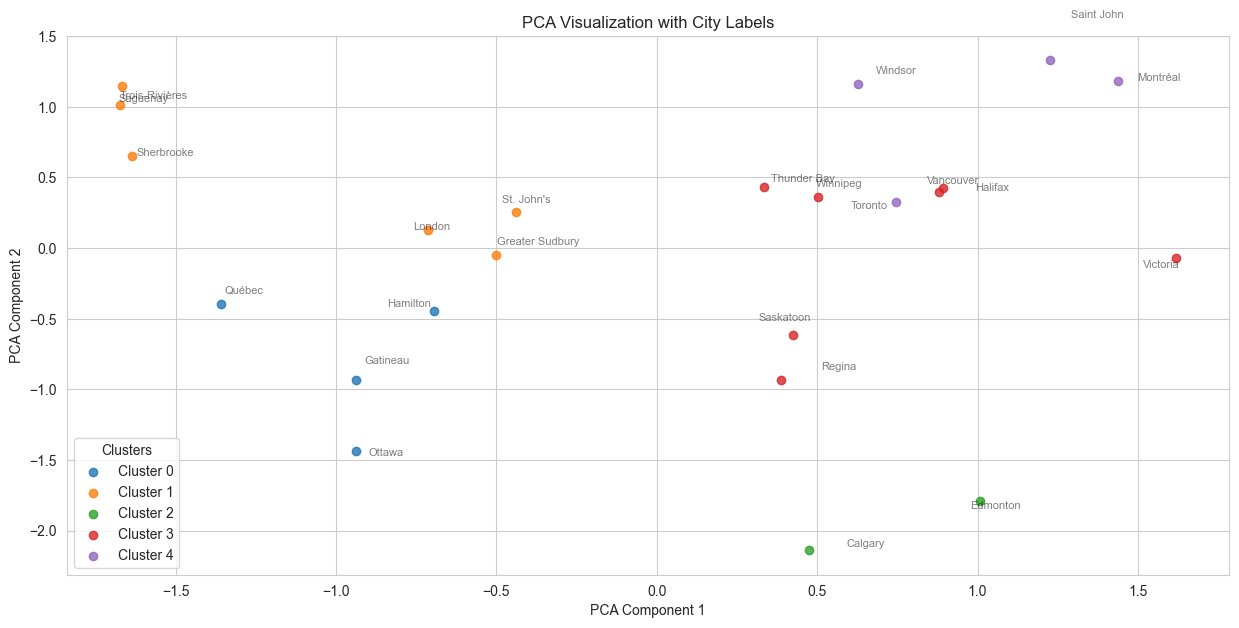

In [15]:
# PCA Plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustered[features])
city_labels = y_clustered["City"].values
explained = pca.explained_variance_ratio_

print(f"PC1 explains {explained[0]*100:.2f}%, PC2 explains {explained[1]*100:.2f}%, Total explained {(explained[1]+explained[0])*100:.2f}%")

plt.figure(figsize=(15, 7))
for cluster in sorted(X_clustered["Cluster"].unique()):
    idx = X_clustered["Cluster"] == cluster
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], color=cluster_colors[cluster], label=f"Cluster {cluster}", alpha=0.8)

for i in range(len(X_pca)):
    jitter_x, jitter_y = np.random.normal(0, 0.1, 2)
    plt.text(X_pca[i, 0] + jitter_x, X_pca[i, 1] + jitter_y, city_labels[i], fontsize=8, color="black", alpha=0.5)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization with City Labels")
plt.legend(title="Clusters")
plt.show()



By introducing a third principal component, the 3D PCA plot provides a more complete view of the underlying structure in the data. Some clusters that appeared overlapping or close together in the 2D PCA plot are now more clearly separated in 3D space — for example, Cluster 4 (purple) is more distinguishable from Cluster 3 (red), and vertical separation reveals greater differences between Clusters 0 and 1. This enhanced dimensionality captures more variance from the original dataset and improves interpretability of cluster groupings, particularly when the top two components alone are insufficient to represent all meaningful variation.

3D PCA: PC1=44.40%, PC2=37.95%, PC3=12.36%, Total explained 94.70%


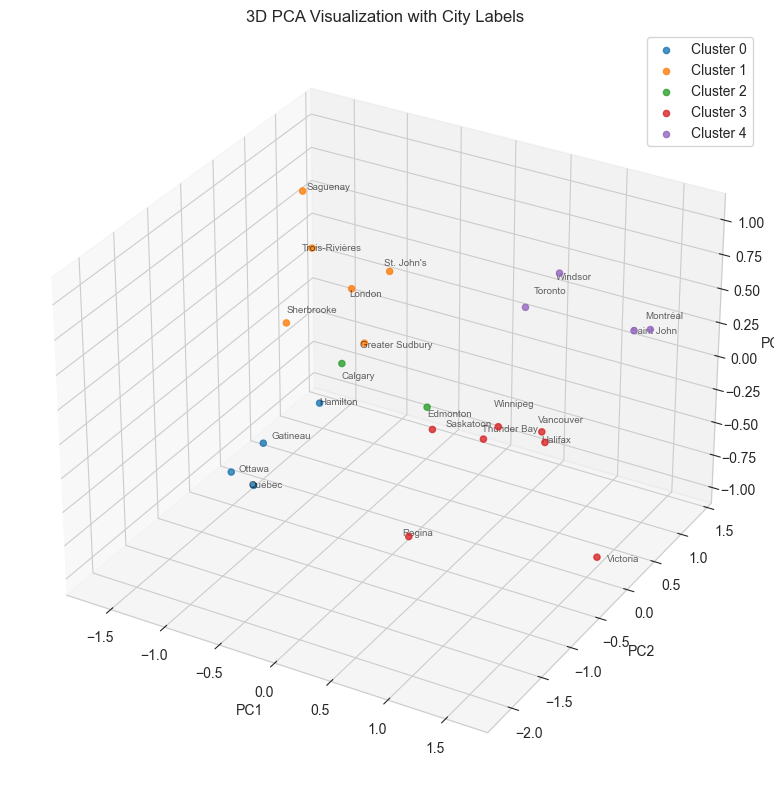

In [16]:

# 3D PCA Plot
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_clustered[features])
city_labels = y_clustered["City"].values
explained = pca.explained_variance_ratio_
print(f"3D PCA: PC1={explained[0]*100:.2f}%, PC2={explained[1]*100:.2f}%, PC3={explained[2]*100:.2f}%, Total explained {(explained[2]+explained[1]+explained[0])*100:.2f}%")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in sorted(X_clustered["Cluster"].unique()):
    idx = X_clustered["Cluster"] == cluster
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], color=cluster_colors[cluster], label=f"Cluster {cluster}", alpha=0.8)

for i in range(len(X_pca)):
    jitter = np.random.normal(0, 0.05, size=3)
    ax.text(*(X_pca[i] + jitter), city_labels[i], fontsize=7, color="black", alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Visualization with City Labels")
ax.legend()
plt.tight_layout()
plt.show()

### Supervised vs. Unsupervised Model Accuracy Comparison
This experiment evaluates how well supervised and unsupervised models classify cities into crime rate categories ("Low", "Medium", "High") across varying training set sizes. A Random Forest classifier is used as the supervised model, while KMeans and Gaussian Mixture Model (GMM) are used for unsupervised clustering. To make the unsupervised results comparable, cluster labels are aligned to true categories using a best-fit mapping. The heatmap shows that the supervised model consistently outperforms the unsupervised approaches, achieving near-perfect accuracy with as little as 10% of the training data. In contrast, KMeans and GMM hover around 57–59% accuracy, showing limited ability to recover the true category structure without labeled supervision. This highlights the value of labeled data for crime prediction and the limitations of clustering when class boundaries are subtle or overlapping.

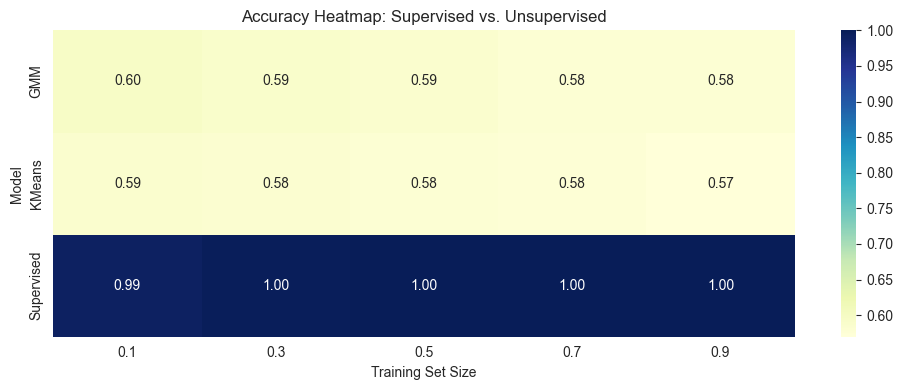

In [17]:
# Run classification and clustering models across varying training sizes,
# evaluates accuracy, and visualizes comparison and confusion matrices.
    
dfStand["CrimeCategory"] = pd.qcut(dfStand["CrimeRate"], q=3, labels=["Low", "Medium", "High"])
X_model = dfStand[["UnemploymentRate", "lowIncImmobRate", "infAdjInc", "policeRate"]].dropna()
crime_labels = dfStand.loc[X_model.index, "CrimeCategory"]

train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]
supervised_accuracies = []
unsupervised_accuracies = {"KMeans": [], "GMM": []}

for size in train_sizes:
    # Split training and test data
    X_train, X_test, y_train, y_test = train_test_split(X_model, crime_labels, train_size=size, random_state=42)

    # Supervised model (Random Forest)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred_sup = clf.predict(X_test)
    supervised_accuracies.append(accuracy_score(y_test, y_pred_sup))

    # Unsupervised: KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X_train)
    test_clusters = kmeans.predict(X_test)
    mapping = get_cluster_label_mapping(kmeans.predict(X_train), y_train)
    y_pred_kmeans = [mapping[c] for c in test_clusters]
    unsupervised_accuracies["KMeans"].append(accuracy_score(y_test, y_pred_kmeans))

    # Unsupervised: GMM
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm.fit(X_train)
    test_clusters = gmm.predict(X_test)
    mapping = get_cluster_label_mapping(gmm.predict(X_train), y_train)
    y_pred_gmm = [mapping[c] for c in test_clusters]
    unsupervised_accuracies["GMM"].append(accuracy_score(y_test, y_pred_gmm))

models = ["Supervised"] + list(unsupervised_accuracies.keys())
data = []

for i, model in enumerate(models):
    if model == "Supervised":
        for size, acc in zip(train_sizes, supervised_accuracies):
            data.append({"Model": model, "Train Size": size, "Accuracy": acc})
    else:
        for size, acc in zip(train_sizes, unsupervised_accuracies[model]):
            data.append({"Model": model, "Train Size": size, "Accuracy": acc})

df_acc = pd.DataFrame(data)
pivot = df_acc.pivot(index="Model", columns="Train Size", values="Accuracy")

plt.figure(figsize=(10, 4))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Accuracy Heatmap: Supervised vs. Unsupervised")
plt.ylabel("Model")
plt.xlabel("Training Set Size")
plt.tight_layout()
plt.show()

### Confusion Matrix Comparison: Supervised vs. Unsupervised Models
These confusion matrices evaluate how well each model classifies cities into High, Medium, and Low crime rate categories, using 90% of the data for training. The Random Forest (supervised) model performs perfectly, with all predictions falling on the diagonal — indicating 100% correct classification. In contrast, both unsupervised models (KMeans and GMM) show clear limitations. They struggle to separate High from Medium crime categories, with most High-crime cities misclassified as Medium. Additionally, about half of the Low category is misclassified, reflecting the challenge of discovering clean cluster boundaries without labeled data. Overall, this confirms the superior accuracy and reliability of the supervised model when ground truth labels are available.

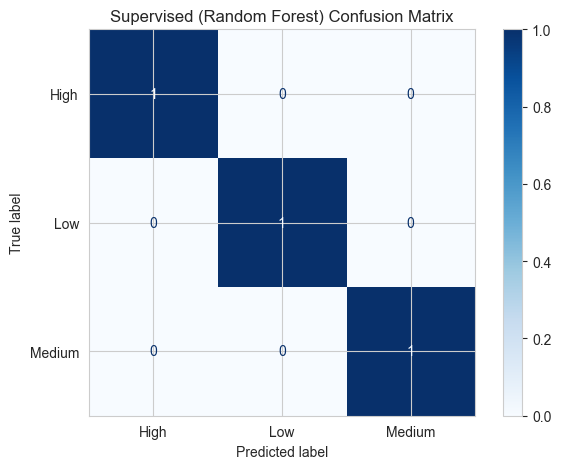

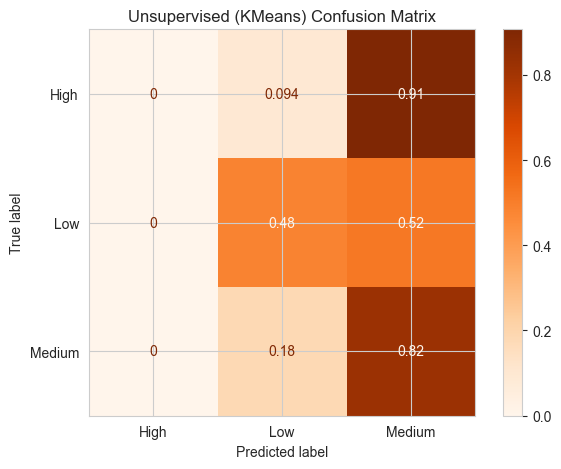

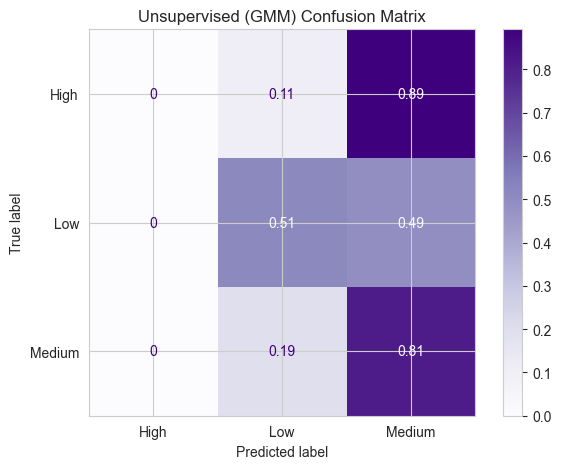

In [18]:
# Plot confusion matrices at 90% training size
X_train, X_test, y_train, y_test = train_test_split(X_model, crime_labels, train_size=0.9, random_state=42)
clf.fit(X_train, y_train)
ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), cmap="Blues", normalize='true')
plt.title("Supervised (Random Forest) Confusion Matrix")
plt.tight_layout()
plt.show()

kmeans.fit(X_train)
mapping = get_cluster_label_mapping(kmeans.predict(X_train), y_train)
y_pred_kmeans = [mapping[c] for c in kmeans.predict(X_test)]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_kmeans, cmap="Oranges", normalize='true')
plt.title("Unsupervised (KMeans) Confusion Matrix")
plt.tight_layout()
plt.show()

gmm.fit(X_train)
mapping = get_cluster_label_mapping(gmm.predict(X_train), y_train)
y_pred_gmm = [mapping[c] for c in gmm.predict(X_test)]
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gmm, cmap="Purples", normalize='true')
plt.title("Unsupervised (GMM) Confusion Matrix")
plt.tight_layout()
plt.show()